**About** : This notebook is used to prepare the data.

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
cd ../src/

/home/tviel/work/kaggle_birdclef_2024/src


### Imports

In [119]:
import os
import sys
import glob
import json
import h5py
import librosa
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
from joblib import delayed
from sklearn.metrics import *

warnings.simplefilter(action="ignore", category=UserWarning)
pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 100)

In [8]:
from params import *
from data.preparation import prepare_data, prepare_folds, prepare_xenocanto_data
from util.plots import display_audio
from data.processing import create_target_path, ProgressParallel, get_load_librosa_save_h5py

## Competiton data

### Data

In [177]:
df = prepare_data()

In [178]:
# prepare_folds()

In [179]:
df.head()

,id,filename,primary_label,secondary_labels,path,fold
0,XC134896,asbfly/XC134896.ogg,asbfly,[],../input/train_audio/asbfly/XC134896.ogg,0
1,XC164848,asbfly/XC164848.ogg,asbfly,[],../input/train_audio/asbfly/XC164848.ogg,2
2,XC175797,asbfly/XC175797.ogg,asbfly,[],../input/train_audio/asbfly/XC175797.ogg,1
3,XC207738,asbfly/XC207738.ogg,asbfly,[],../input/train_audio/asbfly/XC207738.ogg,2
4,XC209218,asbfly/XC209218.ogg,asbfly,[],../input/train_audio/asbfly/XC209218.ogg,1


### Convert to h5py

In [46]:
SAVE_FOLDER = DATA_PATH + "train_features/"

In [47]:
# !rm -rf ^$SAVE_FOLDER

In [48]:
audios = glob.glob(DATA_PATH + "train_audio/*/*")
print(f"-> Found {len(audios)} files")

-> Found 24459 files


In [49]:
targets = [create_target_path(SAVE_FOLDER, f) for f in audios]

os.makedirs(SAVE_FOLDER, exist_ok=True)
for f in set([os.path.dirname(f) for f in targets]):
    os.makedirs(f, exist_ok=True)

print(f"-> Created {len(os.listdir(SAVE_FOLDER))} folders")

-> Created 182 folders


In [50]:
fct = get_load_librosa_save_h5py(do_normalize=False, sr=32000)

fct(audios[0], targets[0])

In [51]:
_ = ProgressParallel(n_jobs=16, total=len(audios))(
    delayed(fct)(load_path, save_path)
    for load_path, save_path in zip(audios, targets)
)

  0%|          | 0/24459 [00:00<?, ?it/s]

100%|██████████| 24459/24459 [00:00<00:00, 27515.85it/s]


In [52]:
saved_targets = glob.glob(SAVE_FOLDER + "*/*.hdf5")
print(f"Saved {len(saved_targets)} files")

Saved 24459 files


In [53]:
df.head()

,id,filename,primary_label,secondary_labels,path,fold
0,XC134896,asbfly/XC134896.ogg,asbfly,[],../input/train_audio/asbfly/XC134896.ogg,1
1,XC164848,asbfly/XC164848.ogg,asbfly,[],../input/train_audio/asbfly/XC164848.ogg,2
2,XC175797,asbfly/XC175797.ogg,asbfly,[],../input/train_audio/asbfly/XC175797.ogg,2
3,XC207738,asbfly/XC207738.ogg,asbfly,[],../input/train_audio/asbfly/XC207738.ogg,2
4,XC209218,asbfly/XC209218.ogg,asbfly,[],../input/train_audio/asbfly/XC209218.ogg,1


## Xenocanto extra data

In [184]:
df_xc = prepare_xenocanto_data()

In [183]:
df_xc[df_xc.duplicated(subset="id", keep=False)].groupby('id').agg(list)

,filename,primary_label,secondary_labels,path,fold
id,,,,,


In [123]:
df_map = pd.read_csv(DATA_PATH + "eBird_Taxonomy_v2021.csv").sort_values('PRIMARY_COM_NAME')

In [132]:
df_map[df_map.SCI_NAME.apply(lambda x: x.lower().startswith('calonectris'))]

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
3791,6866,species,cavshe1,Cape Verde Shearwater,Calonectris edwardsii,Procellariiformes,Procellariidae (Shearwaters and Petrels),NaN,NaN
3788,6863,species,corshe,Cory's Shearwater,Calonectris diomedea,Procellariiformes,Procellariidae (Shearwaters and Petrels),NaN,NaN
3789,6864,issf,scoshe1,Cory's Shearwater (Scopoli's),Calonectris diomedea diomedea,Procellariiformes,Procellariidae (Shearwaters and Petrels),NaN,corshe
3790,6865,issf,corshe1,Cory's Shearwater (borealis),Calonectris diomedea borealis,Procellariiformes,Procellariidae (Shearwaters and Petrels),NaN,corshe
3792,6867,slash,y00676,Cory's/Cape Verde Shearwater,Calonectris diomedea/edwardsii,Procellariiformes,Procellariidae (Shearwaters and Petrels),NaN,NaN
3796,6871,slash,y00606,Cory's/Great Shearwater,Calonectris diomedea/Ardenna gravis,Procellariiformes,Procellariidae (Shearwaters and Petrels),NaN,NaN
3787,6862,species,strshe,Streaked Shearwater,Calonectris leucomelas,Procellariiformes,Procellariidae (Shearwaters and Petrels),NaN,NaN


In [131]:
df_map[df_map.PRIMARY_COM_NAME.apply(lambda x: x.lower().startswith('calonectris'))]

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS


In [134]:
# df_xc[df_xc.secondary_labels.apply(lambda x: "unk" in x)]

### Duplicates

In [46]:
df_tot = pd.concat([df, df_xc])
dups = df_tot[df_tot.duplicated(subset='id', keep=False)].sort_values('id')

In [47]:
# dups[dups['fold'] == -1].id.values.tolist()

In [48]:
dups.head(10)

,id,filename,primary_label,secondary_labels,path,fold
2537,XC163901,bladro1/XC163901.ogg,bladro1,[],../input/train_audio/bladro1/XC163901.ogg,1
10389,XC163901,goflea1/XC163901.ogg,goflea1,[],../input/train_audio/goflea1/XC163901.ogg,1
23422,XC184466,woosan/XC184466.ogg,woosan,[],../input/train_audio/woosan/XC184466.ogg,0
18159,XC184466,marsan/XC184466.ogg,marsan,[],../input/train_audio/marsan/XC184466.ogg,0
2540,XC208794,bladro1/XC208794.ogg,bladro1,[],../input/train_audio/bladro1/XC208794.ogg,1
10397,XC208794,goflea1/XC208794.ogg,goflea1,[],../input/train_audio/goflea1/XC208794.ogg,1
2541,XC208795,bladro1/XC208795.ogg,bladro1,[],../input/train_audio/bladro1/XC208795.ogg,2
10398,XC208795,goflea1/XC208795.ogg,goflea1,[],../input/train_audio/goflea1/XC208795.ogg,2
2543,XC209203,bladro1/XC209203.ogg,bladro1,[],../input/train_audio/bladro1/XC209203.ogg,2
10399,XC209203,goflea1/XC209203.ogg,goflea1,[],../input/train_audio/goflea1/XC209203.ogg,2


In [49]:
idx = 0

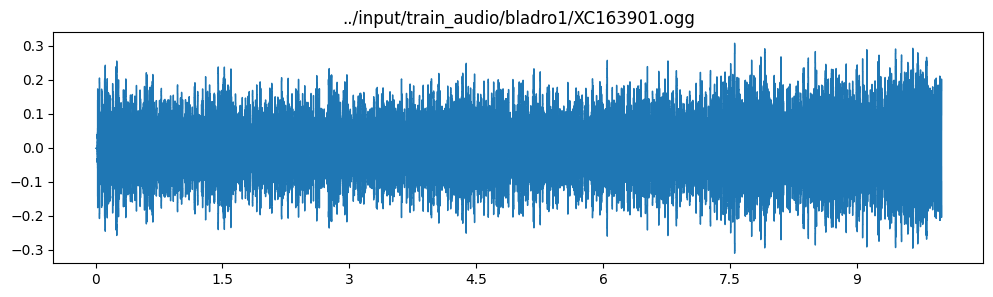

In [51]:
display_audio(dups["path"].values[idx])

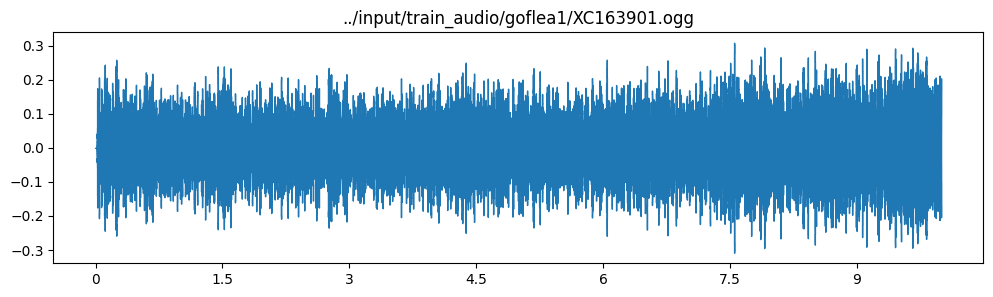

In [52]:
display_audio(dups["path"].values[idx + 1])

### Data

In [34]:
audios = glob.glob(DATA_PATH + "xenocanto/audio/*/*")
print(f"-> Found {len(audios)} files")

-> Found 24268 files


In [35]:
SAVE_FOLDER = DATA_PATH + "xenocanto/features/"

In [36]:
targets = [create_target_path(SAVE_FOLDER, f) for f in audios]

os.makedirs(SAVE_FOLDER, exist_ok=True)
for f in set([os.path.dirname(f) for f in targets]):
    os.makedirs(f, exist_ok=True)

print(f"-> Created {len(os.listdir(SAVE_FOLDER))} folders")

-> Created 182 folders


In [37]:
fct = get_load_librosa_save_h5py(do_normalize=False, sr=32000)
fct(audios[0], targets[0])

In [38]:
_ = ProgressParallel(n_jobs=16, total=len(audios))(
    delayed(fct)(load_path, save_path)
    for load_path, save_path in zip(audios, targets)
)

  0%|          | 0/24268 [00:00<?, ?it/s]

100%|██████████| 24268/24268 [03:07<00:00, 129.61it/s]


In [39]:
saved_targets = glob.glob(SAVE_FOLDER + "*/*.hdf5")
print(f"Saved {len(saved_targets)} files")

Saved 24268 files


### Convert to h5py

In [ ]:
species_2024 = 

Done !